In [1]:
# pip install git+https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator
from testing import test_3a, test_3b, test_3c 

En la escuela aprendimos sobre el protocolo BB84 para criptografía cuántica. Este es la primera y más simple propuesta para realizar criptografía cuántica, y se basa en que Alice envía estados aleatorios a Bob para que este los mida. Una caracterisitica de este protocolo es que __no requiere entrelazamiento__. Sin embargo, existen otros protocolos de criptografía cuántica que si emplean estados entrelazados. En este desafío implementaremos uno de estos, el __EKERT91__.

El primer paso es que Alice y Bob generen una lista de trits (0, 1, o 2).

In [3]:
num_trits = 10000
alice_random_trits = np.random.randint(0,3,size=num_trits)
bob_random_trits = np.random.randint(0,3,size=num_trits)
print('Alice trits =', alice_random_trits )
print('')
print('Bob trits =', bob_random_trits )

Alice trits = [2 0 0 ... 1 0 1]

Bob trits = [0 2 1 ... 2 0 2]


Estos trits serán usados para crear circuitos cuánticos aleatorios combinando los siguientes circuitos para Alice y Bob

(poner figura acá)

__Desafío:__ Complete los circuitos de la siguiente celda para que implementen todos los circuitos anteriores. Las listas ``Aj`` y ``Bj`` contienen los circuitos de Alice y Bob, respectivamente. 

In [4]:
qa = QuantumRegister(1, name='Alice')
qb = QuantumRegister(1, name='Bob')

############
qc_a0 = QuantumCircuit(qa)

qc_a1 = QuantumCircuit(qa)
qc_a1.ry( -np.pi/4, 0 )

qc_a2 = QuantumCircuit(qa)
qc_a2.ry( -np.pi/2, 0 )

Aj = [qc_a0,qc_a1,qc_a2]

###########
qc_b0 = QuantumCircuit(qb)
qc_b0.ry( -np.pi/4, 0 )

qc_b1 = QuantumCircuit(qb)
qc_b1.ry( -np.pi/2, 0 )

qc_b2 = QuantumCircuit(qb)
qc_b2.ry( -3*np.pi/4, 0 )

Bk = [qc_b0,qc_b1,qc_b2]

In [5]:
test_3a( Aj, Bk )

Felicitaciones, tu solución es correcta!


El Ekert91 emplea un estado maximalmente estrelazado llamado singlete
\begin{equation}
    | \psi \rangle = \frac{1}{\sqrt{2}}\left( |01\rangle - |10\rangle \right). 
\end{equation}
Este estado toma el rol de canal cuántico para la comunicación, enviando uno de los qubits a Alice y el otro a Bob. Posteriormente, Alice y Bob utilizan sus trits aleatorios y aplican alguno de los circuitos anteriores a su correspondiente qubit. El circuito completo tiene la siguiente forma:

(figura acá)

Acá $U_\psi$ es una operación unitaria que prepara el estado singlete, es decir $|\psi\rangle=U_\psi|00\rangle$, mientras que $A_j$ y $B_k$ son los circuitos contenidos en las listas ``Aj`` y ``Bk``, con $j,k\in\{0,1,2\}$. 

__Desafío:__ Construya estos circuitos para cada par de trits de Alice y Bob. 

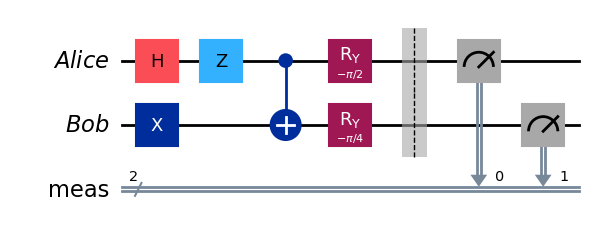

In [6]:
qcs = []
for j in range(num_trits):
    qc = QuantumCircuit( qa, qb ) 
    qc.h(0)
    qc.x(1)
    qc.z(0)
    qc.cx(0,1)
    qc.compose( Aj[alice_random_trits[j]], qubits=qa, inplace=True )
    qc.compose( Bk[bob_random_trits[j]], qubits=qb, inplace=True )
    qc.measure_all()
    qcs.append(qc) 
qcs[0].draw('mpl') 

In [7]:
test_3b( qcs ) #takes a while

Felicitaciones, tu solución es correcta!


Simulando los experiementos de cada uno de esto circuitos.

In [8]:
simulator = AerSimulator()

job = simulator.run( qcs, shots=1 )
counts_ekert = job.result().get_counts()

QiskitError: 'No counts for experiment "0"'

Despues de las medidas, Alice y Bob hacen publicos sus listas de trits y separan sus medidas en dos grupos. El primer grupo consiste en aquellos con trits $(a,b)\in \{ (0,0), (0,2), (2,0), (2,2) \}$. Estas mediciones nos permiten verificar si hay algún espía en la comunicación gracias al teorema e Bell. Para esto debemos evaluar la siguiente cantidad

\begin{equation}
    S = E_{00} - E_{02} + E_{20} + E_{22},
\end{equation}
donde 
\begin{equation}
    E_{jk} = p(00|jk) + p(00|jk) - p(01|jk) - p(10|jk),
\end{equation}
y $p(lm|jk)$ es la probabilidad de obtener el resultado $lm$ al medir el circuito $jk$.

Esta cantidad debe tener un valor $|S|\approx 2\sqrt{2}$, lo cual representa que el estado esta maximalmente entrelazado. En el caso que $|S|<2\sqrt{2}$ se tiene que el canal ha perdido entrelazamiento, la cual se puede deber, entre otras cosas, a la presencia de un espía en la comunicación. La siguiente celda calcula $S$. 

In [8]:
bell = 0

ExpVal = np.zeros([3,3])
times_per_ExpVal = np.zeros([3,3])

for j in range(num_trits):

    a = alice_random_trits[j]
    b = bob_random_trits[j]

    E = counts_ekert[j].get('00',0) + counts_ekert[j].get('11',0) - counts_ekert[j].get('10',0) - counts_ekert[j].get('01',0)

    ExpVal[a,b] += E 
    times_per_ExpVal[a,b] += 1 

ExpVal = ExpVal / times_per_ExpVal

S = ExpVal[ 0,0 ] - ExpVal[ 0,2] + ExpVal[ 2,0 ] + ExpVal[ 2,2]

print( S ) 

-2.8683465481483097


El segundo grupo son aquellos con trits $(a,b)\in\{(1,0),(2,1)\}$. Las mediciones de estos circuitos estarán anticorrelacionadas debido al estado singlete, es decir, si Alice mide 0, Bob medirá 1, y viceversa. Esta estructura nos permite establecer una llave compartida entre Alice y Bob.

__Desafío:__ Contruya la llave secreta.

In [92]:
key = []
for j in range(num_trits):

    a = alice_random_trits[j]
    b = bob_random_trits[j]

    if (a==1 and b==0) or (a==2 and b==1):
        key.append( list(counts_ekert[j].keys())[0][0] )

print( key ) 

['0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '1', '1', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '0', '1',

In [99]:
test_3c( key, alice_random_trits, bob_random_trits  )

Felicidades, tu clave es segura
